# Zee: Zero Effort Crowdsourcing for Indoor Localization

This notebook implements the algorithm described in the Zee paper.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import json

from pathlib import Path
from datetime import datetime

In [2]:
import shapely

In [3]:
import sklearn

In [4]:
import scipy

In [5]:
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

In [6]:
import shapely.vectorized

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code", "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [9]:
# type: ignore
from compute_f import split_ts_seq, compute_step_positions
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap, save_figure_to_html

In [10]:
floor_data_dir = os.path.join(INDOOR_COMPETITION_20_DIR, "data", "site1", "F2")
path_data_dir = os.path.join(floor_data_dir, "path_data_files")
floor_plan_filename = os.path.join(floor_data_dir, "floor_image.png")
floor_info_filename = os.path.join(floor_data_dir, "floor_info.json")
floor_map_filename  = os.path.join(floor_data_dir, "geojson_map.json")

## Data Extraction

In [11]:
path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

In [12]:
path_filename = path_filenames[0]
path_datas = read_data_file(path_filename)

In [13]:
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint

In [14]:
gt_times = path_datas.waypoint[:, 0]
gt_location = path_datas.waypoint[:, 1:]

## Counting Steps

In [15]:
ts = path_datas.acce[:, 0].astype(np.int64)

acce_x = path_datas.acce[:, 1]
acce_y = path_datas.acce[:, 2]
acce_z = path_datas.acce[:, 3]

# a = sqrt(ax*ax + ay*ay + az*az)
acce = np.sqrt(np.sum(path_datas.acce[:, 1:]**2, axis=1))

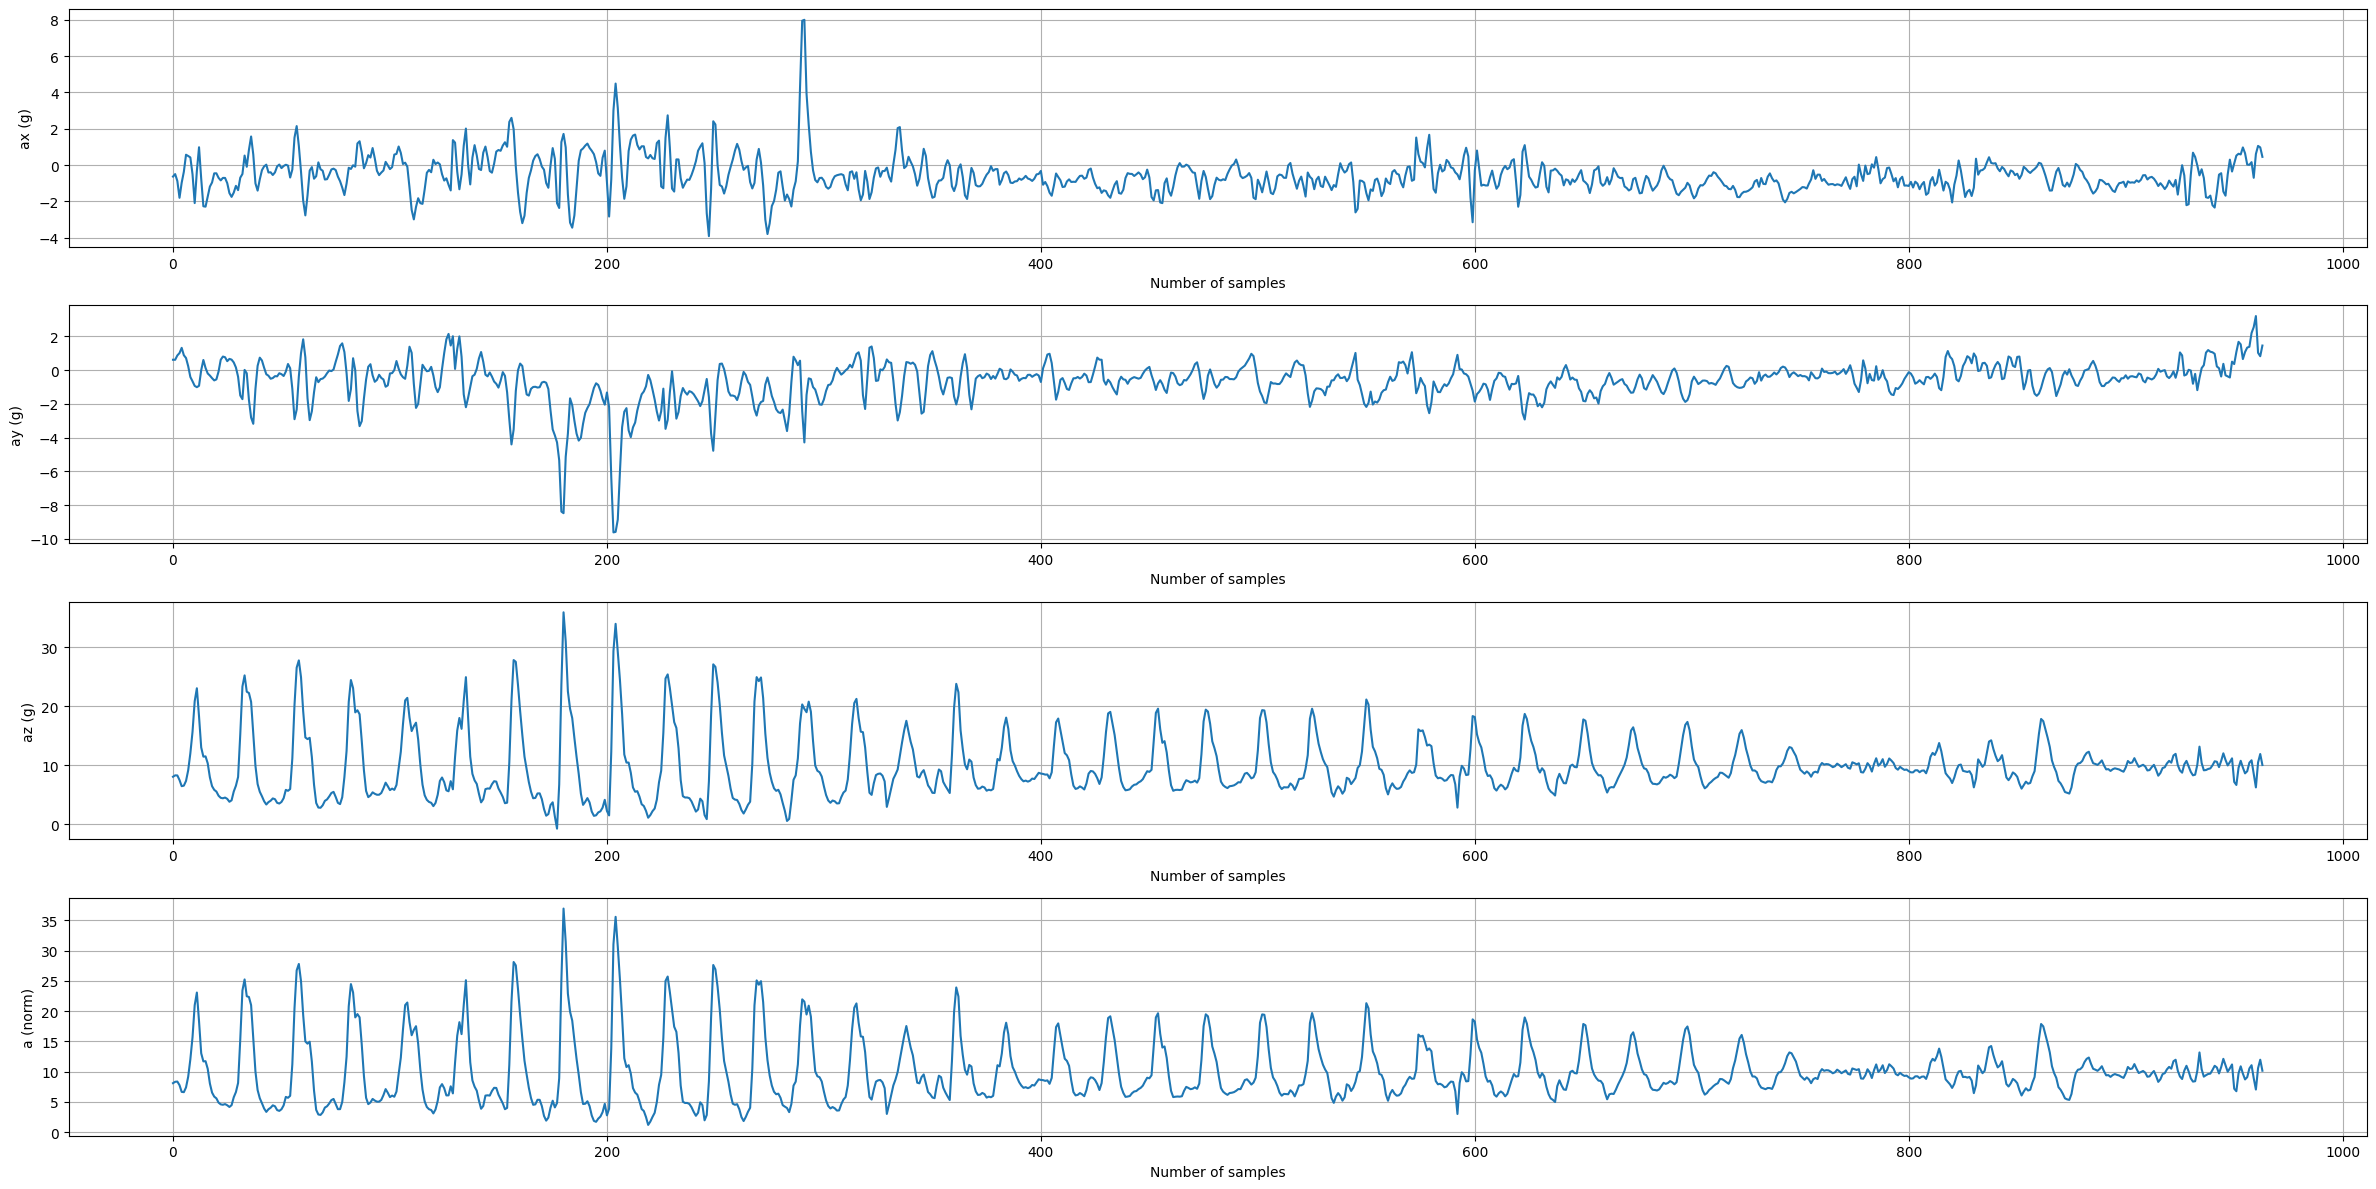

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(24, 12),)

ax1.plot(acce_x)
ax1.set_ylabel("ax (g)")
ax1.set_xlabel("Number of samples")

ax2.plot(acce_y)
ax2.set_ylabel("ay (g)")
ax2.set_xlabel("Number of samples")

ax3.plot(acce_z)
ax3.set_ylabel("az (g)")
ax3.set_xlabel("Number of samples")

ax4.plot(acce)
ax4.set_ylabel("a (norm)")
ax4.set_xlabel("Number of samples")

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.tight_layout()
plt.show()

### Applying Low-pass Filter

In [17]:
def low_pass_filter(acc, alpha):
  n = len(acc)
  f_acc = np.zeros_like(acc)
  f_acc[0] = acc[0]
  for i in range(1, n):
    f_acc[i] = alpha * f_acc[i - 1]  + (1 - alpha) * acc[i]
  return f_acc

In [18]:
def high_pass_filter(acc, alpha):
  n = len(acc)
  f_acc = np.zeros_like(acc)
  f_acc[0] = acc[0]
  for i in range(1, n):
    f_acc[i] = alpha * f_acc[i - 1] + alpha * (acc[i] - acc[i - 1])
  return f_acc

In [19]:
hpf = high_pass_filter(acce, alpha=0.98)

In [20]:
def filter_and_plot_signal(signal, sampling_freq, figsize=(18, 6)):
  alpha = 1.0 / (1.0 + 1.0 / sampling_freq)
  lpf = low_pass_filter(signal, alpha=alpha)
  hpf = high_pass_filter(signal, alpha=alpha)

  fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=figsize)
  
  ax.plot(signal, label="original")
  ax.plot(lpf, label="low-pass", color="red")
  ax.plot(hpf, label="high-pass", color="green")
  ax.set_ylabel("signal")
  ax.set_xlabel("Number of samples")
  ax.legend()

  plt.tight_layout()
  plt.show()

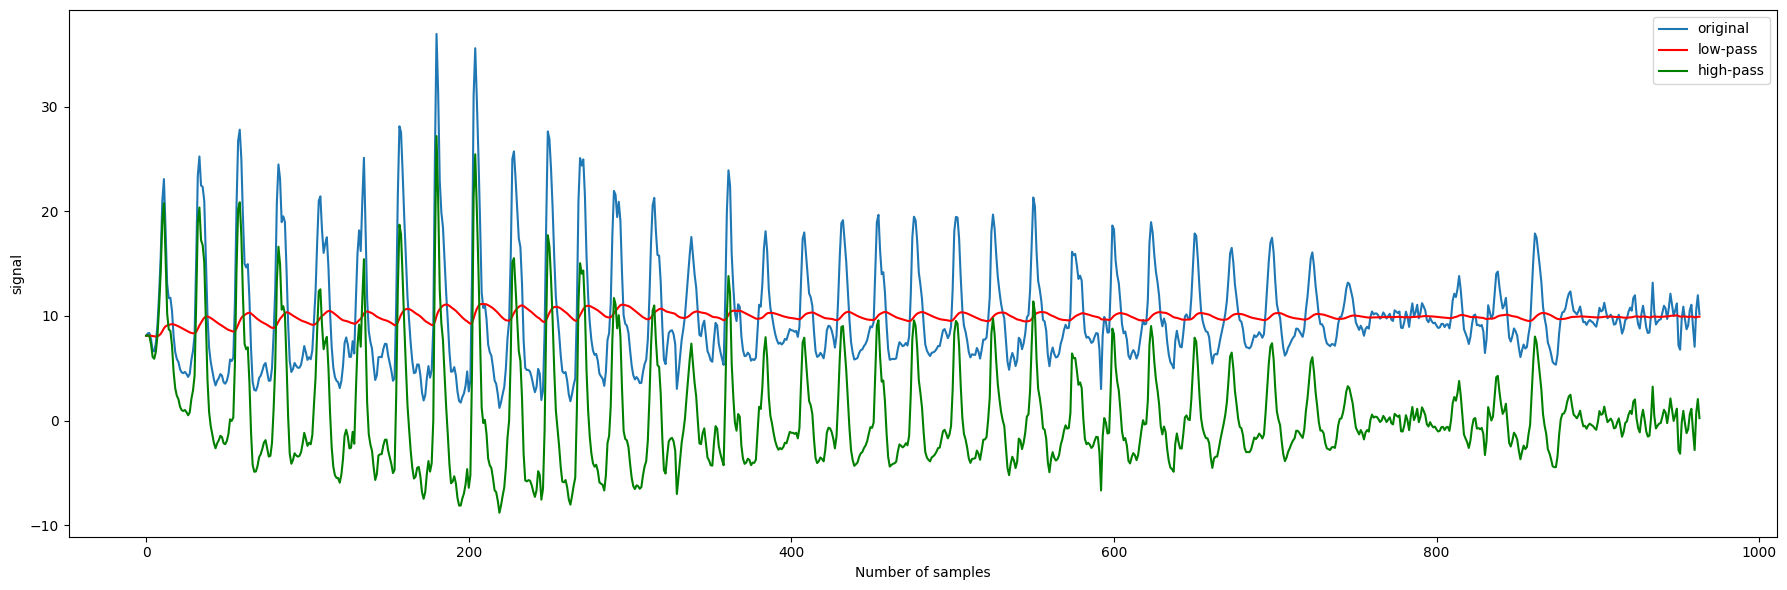

In [21]:
filter_and_plot_signal(signal=acce, sampling_freq=50)

### Normalized Auto-correlation based Step Counting (NASC)

* The intuition behind NASC is that if the user is walking, then the auto-correlation will spike at the correct periodicity of the walker.

In [22]:
def norm_acf(a, m, t):
  mu_m, sigma_m = np.mean(a[m:m+t], axis=0), np.std(a[m:m+t], axis=0)
  mu_mt, sigma_mt = np.mean(a[m+t:m+t*2], axis=0), np.std(a[m+t:m+t*2], axis=0)

  n_acf = np.sum((a[m:m+t] - mu_m) * (a[m+t:m+t*2] - mu_mt), axis=0) / t / sigma_m / sigma_mt

  return np.mean(n_acf)

In [23]:
acc_sampling_freq = ts.shape[0] / (ts[-1] / 1000 - ts[0] / 1000)
print(
    "The sampling frequency of accelerometer is {:.2f}Hz".format(acc_sampling_freq)
)

The sampling frequency of accelerometer is 49.71Hz


In [24]:
def max_norm_acf(a, m, t_min=40, t_max=100):
  """
  Finding the maximum normalized auto-correlation.
  """
  t_best = t_min
  n_acf_best = norm_acf(a, m, t_best)
  for t in range(t_min, t_max + 1):
    n_acf = norm_acf(a, m, t)
    if n_acf > n_acf_best:
      t_best = t
      n_acf_best = n_acf
  return n_acf_best, t_best


In [25]:
STATE_IDLE = "IDLE"
STATE_WALKING = "WALKING"

def get_state(acce, m, prev_state=None, prev_t_opt=None):
  if prev_t_opt is not None:
    t_min, t_max = max(40, prev_t_opt - 10), min(100, prev_t_opt + 10)
  else:
    t_min, t_max = 40, 100
  
  n_acf, t_opt = max_norm_acf(acce, m=m, t_min=t_min, t_max=t_max)
  
  sigma = np.mean(np.std(acce[m:m+t_opt], axis=0))
  if sigma < 0.01:
    return STATE_IDLE, t_opt
  
  if n_acf > 0.7:
    return STATE_WALKING, t_opt
  
  return prev_state, t_opt


In [26]:
get_state(acce, m=50)

('WALKING', 50)

## Estimating Heading Offset Range

### Estimating Heading

* Heading is the $\theta$ from the paper, which is the compass value.

In [27]:
def get_rotation_matrix(gravity, geomagnetic, R):
  """
  https://android.googlesource.com/platform/frameworks/base/+/master/core/java/android/hardware/SensorManager.java
  """
  ax = gravity[0]
  ay = gravity[1]
  az = gravity[2]

  norm_sq_a = ax * ax + ay * ay + az * az
  g = 9.81

  free_fall_gravity_squared = 0.01 * g * g

  if norm_sq_a < free_fall_gravity_squared:
    # gravity is less than 10% of normal value
    return False
  
  ex = geomagnetic[0];
  ey = geomagnetic[1];
  ez = geomagnetic[2];
  hx = ey * az - ez * ay;
  hy = ez * ax - ex * az;
  hz = ex * ay - ey * ax;

  norm_h = np.sqrt(hx * hx + hy * hy + hz * hz);
  
  if norm_h < 0.1:
    # device is close to free fall, or close to magnetic north pole, typical values are > 100
    return False
  
  inv_h = 1.0 / norm_h
  hx *= inv_h
  hy *= inv_h
  hz *= inv_h

  inv_a = 1.0 / np.sqrt(norm_sq_a)
  ax *= inv_a
  ay *= inv_a
  az *= inv_a
  mx = ay * hz - az * hy
  my = az * hx - ax * hz
  mz = ax * hy - ay * hx

  if R is not None:
    if len(R) == 9:
      R[0] = hx; R[1] = hy; R[2] = hz
      R[3] = mx; R[4] = my; R[5] = mz
      R[6] = ax; R[7] = ay; R[8] = az
    elif len(R) == 16:
      R[0] = hx; R[1] = hy; R[2] = hz; R[3] = 0
      R[4] = mx; R[5] = my; R[6] = mz; R[7] = 0
      R[8] = ax; R[9] = ay; R[10] = az; R[11] = 0
      R[12] = 0; R[13] = 0; R[14] = 0; R[15] = 1

  return True

In [28]:
def get_orientation(R, values):
  """
  values[0]: azimuth
  values[1]: pitch
  values[2]: roll
  """
  if len(R) == 9:
    values[0] = np.arctan2(R[1], R[4])
    values[1] = np.arcsin(-R[7])
    values[2] = np.arctan2(-R[6], R[8])
  else:
    values[0] = np.arctan2(R[1], R[5])
    values[1] = np.arcsin(-R[9])
    values[2] = np.arctan2(-R[8], R[10])

  return values

In [29]:
R = np.zeros(9, dtype=np.float64)
orientation = np.zeros(3, dtype=np.float64)
gravity = path_datas.acce[0]
geomagnetic = path_datas.magn[0]

result = get_rotation_matrix(gravity, geomagnetic, R)
if result:
  get_orientation(R, orientation)
  theta = np.degrees(orientation[0])
  print(f"theta={theta:.2f}")

theta=107.42


In [30]:
# Heading estimation

n = len(path_datas.acce)

heading_values = np.zeros(n, dtype=np.float32)

R = np.zeros(9, dtype=np.float64)
orientation = np.zeros(3, dtype=np.float64)

for i in range(n):
  result = get_rotation_matrix(path_datas.acce[i], path_datas.magn[i], R)
  if result:
    get_orientation(R, orientation)
    heading_values[i] = np.degrees(orientation[0])
  else:
    heading_values[i] = heading_values[i - 1]

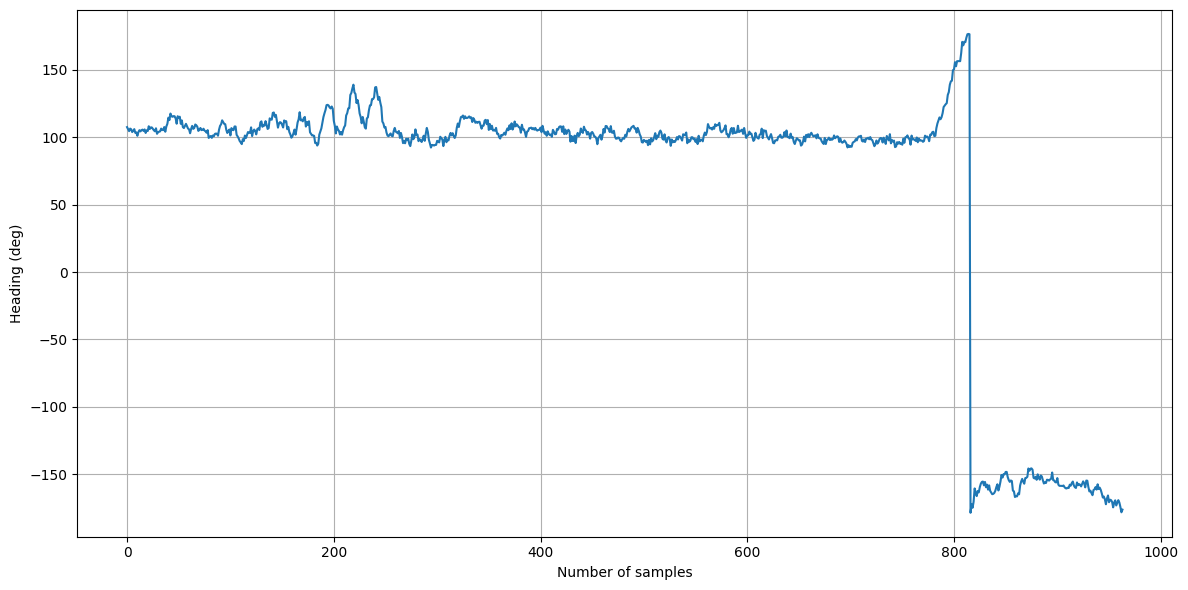

In [31]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
  
ax.plot(heading_values, label="heading")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()

plt.tight_layout()
plt.show()

### Spectrum of a Typical Walk

* After observing the Fourier transform across several uses and placements, the authors discovered an interesting fact: *the second harmonic is either completely absent or is extremely weak in the accelerations experienced by the phone in the direction perpendicular to the user's walk. It is however always present and dominant in the direction parallel to the user's walk.*
* What are implications of this observation? - We can estimate the possible values for the sum `magnetic_offset + heading_offset + compass` from the magnitude of the second harmonic in teh Fourier transform along north `Fy` and along west `Fx`
  * `magnetic_offset + heading_offset + compass = arctan(Fx/Fy)`
  * OR `magnetic_offset + heading_offset + compass = arctan(Fx/Fy) + 180`

In [32]:
def show_spectrum(signal_data, fs, figsize=(10, 6)):
  n_samples = len(signal_data)
  duration = n_samples / fs
  t = np.linspace(0, duration, int(fs * duration), endpoint=False)

  frequencies, spectrum = scipy.signal.periodogram(signal_data, fs=fs)

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

  ax1.plot(t, signal_data)
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")
  ax1.set_title("Time Domain Signal")

  ax2.plot(frequencies, spectrum)
  ax2.set_xlabel("Frequency (Hz)")
  ax2.set_ylabel("Magnitude")
  ax2.set_title("Frequency Spectrum")

  plt.tight_layout()
  plt.show()

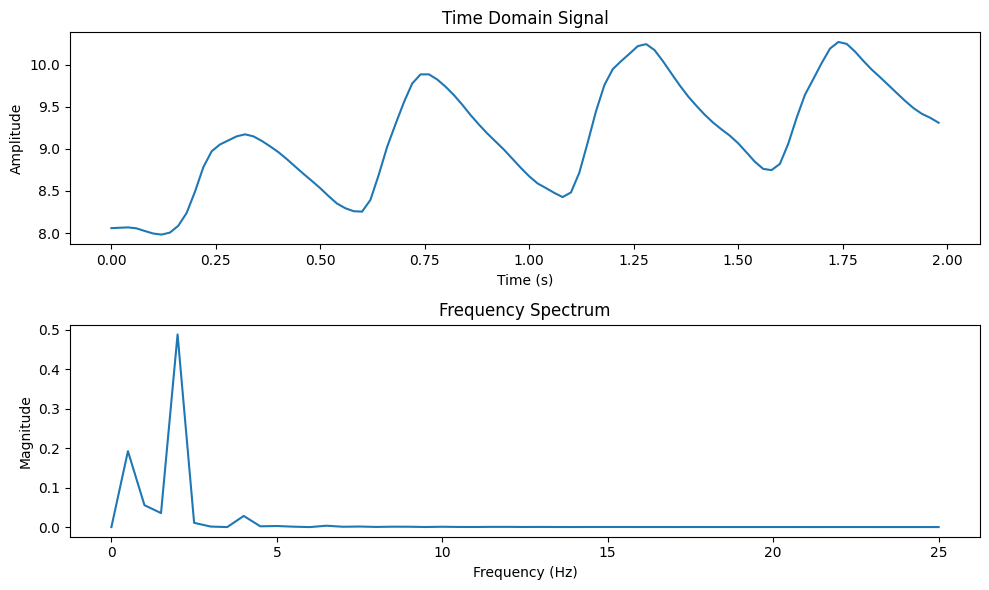

In [33]:
show_spectrum(low_pass_filter(acce_z[0:100], alpha=0.98), fs=50)

In [34]:
def find_fundamental_frequency(frequencies, spectrum):
  idx = np.argmax(spectrum)
  return frequencies[idx], spectrum[idx]

In [35]:
def find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics=[2,3,4]):
  fundamental_frequency, amplitude = find_fundamental_frequency(frequencies, spectrum)
  harmonics_found = [harmonic for harmonic in harmonics if harmonic * fundamental_frequency in frequencies]
  return fundamental_frequency, amplitude, harmonics_found

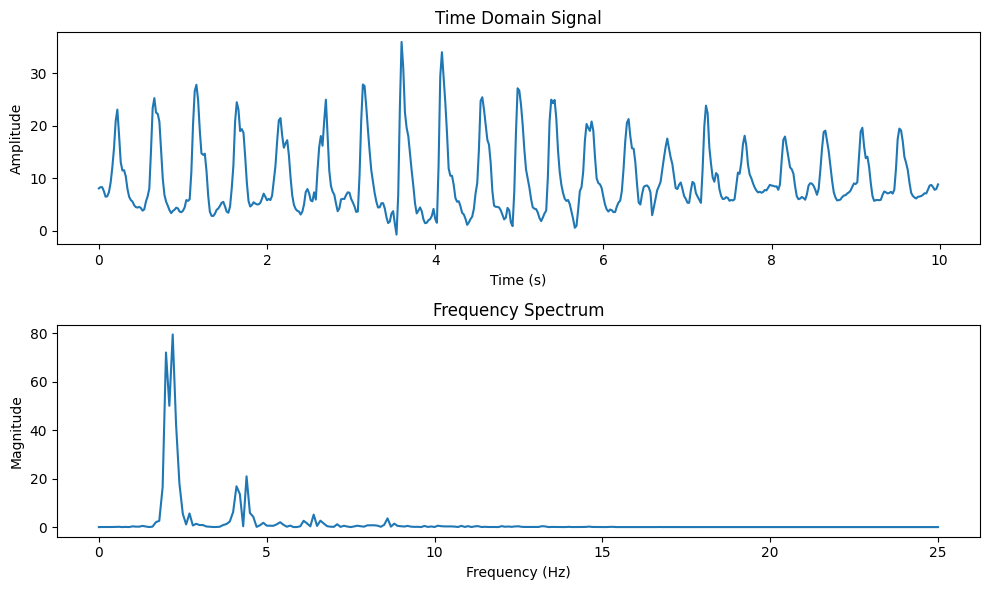

Fundamental Frequency: 2.2 Hz, Magnitude: 79.43
Harmonics Found: [2, 3, 4]


In [36]:
show_spectrum(acce_z[:500], fs=50)

# Find the fundamental frequency and its harmonics
frequencies, spectrum = scipy.signal.periodogram(acce_z[:500], fs=50)
harmonics = [2, 3, 4]
fundamental_frequency, amplitude, harmonics_found = find_fundamental_frequency_and_harmonics(frequencies, spectrum, harmonics)

print(f"Fundamental Frequency: {fundamental_frequency} Hz, Magnitude: {amplitude:.2f}")
print(f"Harmonics Found: {harmonics_found}")

In [ ]:
def find_fx_fy(path_acce_data, verbose=False):
  ts = path_acce_data[:, 0]
  ax = path_acce_data[:, 1]
  ay = path_acce_data[:, 2]
  az = path_acce_data[:, 3]

  sampling_period = np.mean((ts[:-1] - ts[:1]) / 1000)
  sampling_freq = 1.0 / sampling_period
  if verbose:
    print(f"sampling_period={sampling_period}, sampling_freq={sampling_freq}")
  
  fx, sx = scipy.signal.periodogram(ax, fs=sampling_freq)
  fy, sy = scipy.signal.periodogram(ay, fs=sampling_freq)
  fz, sz = scipy.signal.periodogram(az, fs=sampling_freq)

In [58]:
fx, sx = scipy.signal.periodogram(acce_x, fs=50)
fy, sy = scipy.signal.periodogram(acce_y, fs=50)
fz, sz = scipy.signal.periodogram(acce_z, fs=50)

In [60]:
ix = np.argmax(sx)
iy = np.argmax(sy)
iz = np.argmax(sz)

In [66]:
funda_fx, funda_sx = fx[ix], sx[ix]
funda_fy, funda_sy = fy[iy], sy[iy]
funda_fz, funda_sz = fz[iz], sz[iz]

In [67]:
funda_fx, funda_fy, funda_fz, funda_sx, funda_sy, funda_sz

(0.051867219917012444,
 0.10373443983402489,
 2.1265560165975104,
 1.2755316414463556,
 3.714261580761103,
 106.05867290439744)

In [106]:
# Finding the fundamental frequency and the associated magnitude

sx[iz*2+2], sy[iz*2+2], sz[iz*2+2]

(0.021784138816144733, 0.24546921527759877, 5.616992184845565)

In [112]:
np.degrees(np.arctan(sz[iz*2+2]/sy[iz*2+2]))

87.49769868222076

In [81]:
funda_fz * 2 in fz

True

In [ ]:
9.381124611395677 / 

In [ ]:
np.arctan()

### Magnetic Offsets

* Heading computation from ground-truth location

In [187]:
gt_x = gt_location[:, 0]
gt_y = gt_location[:, 1]

gt_heading_values = np.degrees(np.arctan((gt_y[1:] - gt_y[:-1]) / (gt_x[1:] - gt_x[:-1])))

In [188]:
ts = path_datas.acce[:, 0]
min_time, max_time, n_samples = ts.min(), ts.max(), len(ts)

In [189]:
gt_ts = path_datas.waypoint[:-1, 0]
gt_ts_frac = (gt_ts - min_time) / (max_time - min_time) * n_samples
gt_ts_frac = np.rint(np.clip(gt_ts_frac, a_min=0, a_max=n_samples)).astype(np.int64)

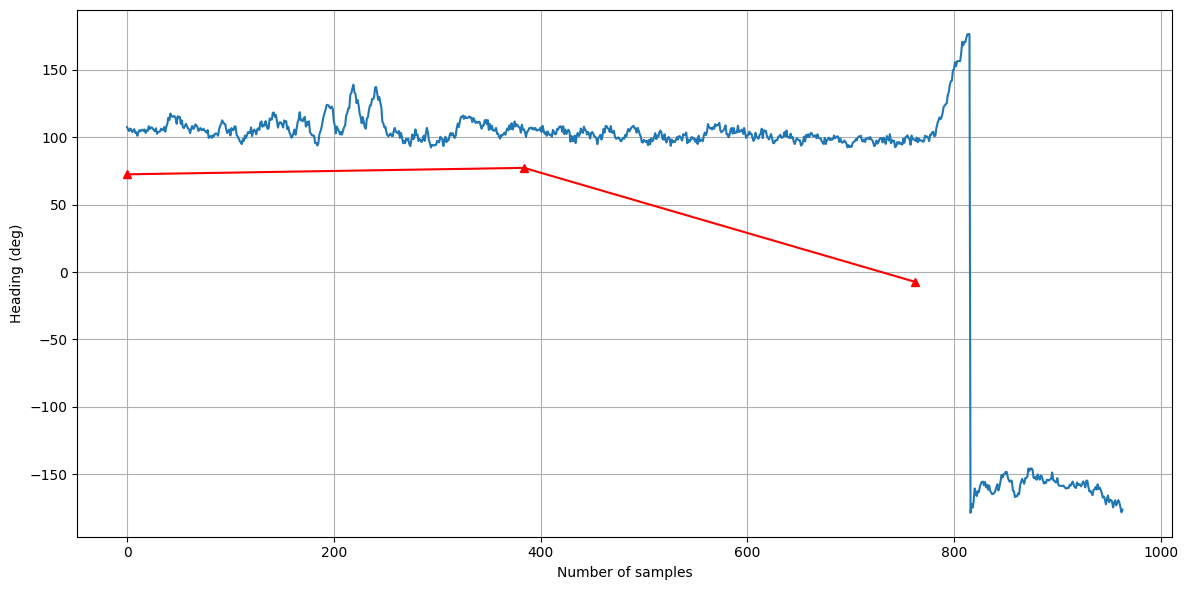

In [190]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
  
ax.plot(heading_values, label="heading")
ax.plot(gt_ts_frac, gt_heading_values, marker="^", color="red", label="ground-truth")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()

plt.tight_layout()
plt.show()

* We have to rotate the original coordinate system into a coordinate system in which `Ox` points North.
* The equation for rotation could be found here: https://en.wikipedia.org/wiki/Rotation_of_axes_in_two_dimensions

In [264]:
def rotate(xs, ys, a):
  xs = np.atleast_1d(xs)
  ys = np.atleast_1d(ys)

  r_xs = xs * np.cos(a) + ys * np.sin(a)
  r_ys = -1 * xs * np.sin(a) + ys * np.cos(a)

  return r_xs, r_ys  

In [266]:
# sanity check
r_xs, r_ys = rotate(np.sqrt(3), 1, np.pi / 6)
assert np.isclose(r_xs[0], 2)
assert np.isclose(r_ys[0], 0)

r_xs, r_ys = rotate(7, 7, -np.pi / 2)
assert np.isclose(-7, r_xs[0])
assert np.isclose(7, r_ys[0])

In [267]:
# TODO: Rotation angle estimation using multiple data points

gt_x = gt_location[:, 0]
gt_y = gt_location[:, 1]

k1 = (gt_y[1] - gt_y[0]) / (gt_x[1] - gt_x[0])
k2 = np.tan(np.radians(heading_values[0]))

rotation_angle = np.arctan((k1 - k2) / (1 + k1 * k2))
print(f"rotation_angle: {rotation_angle:.2f} (rad), {np.degrees(rotation_angle):.2f} (deg)")

rotation_angle: -0.61 (rad), -34.99 (deg)


In [226]:
np.degrees(np.arctan((r_gt_y[1] - r_gt_y[0]) / (r_gt_x[1] - r_gt_x[0]))) + 180

107.41577637236938

In [223]:
np.degrees(rotation_angle)

-34.990318554777346

In [217]:
r_gt_x, r_gt_y = rotate(gt_location[:, 0], gt_location[:, 1], rotation_angle)

In [229]:
r_gt_heading_values = np.degrees(np.arctan((r_gt_y[1:] - r_gt_y[:-1]) / (r_gt_x[1:] - r_gt_x[:-1])))
r_gt_heading_values = (r_gt_heading_values + 180) % 180  # avoid obstue angle

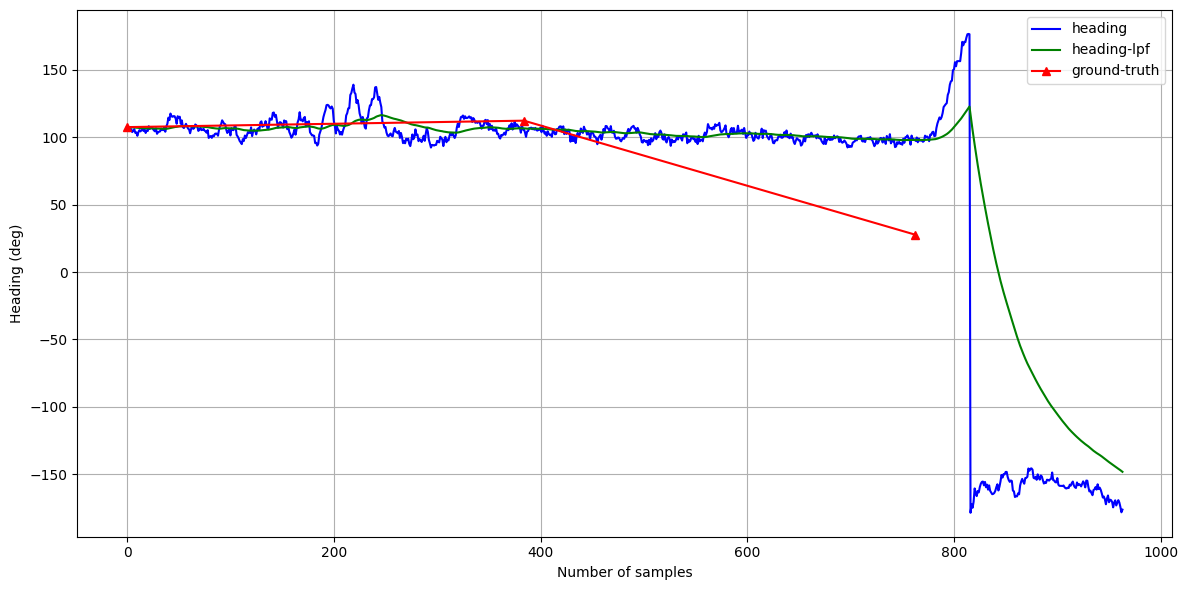

In [233]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
  
ax.plot(heading_values, label="heading", color="blue")
ax.plot(low_pass_filter(heading_values, 0.98), label="heading-lpf", color="green")
ax.plot(gt_ts_frac, r_gt_heading_values, marker="^", color="red", label="ground-truth")
ax.set_ylabel("Heading (deg)")
ax.set_xlabel("Number of samples")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

## Augmented Particle Filter

### Map Data Preprocessing

In [113]:
with open(floor_info_filename) as f:
  floor_info = json.load(f)

In [114]:
with open(floor_map_filename) as f:
  floor_map = json.load(f)

In [115]:
floor_info

{'map_info': {'height': 176.66380763697, 'width': 239.81749314504376}}

In [116]:
def parse_polygon_coordinates(geojson_feature):
  polygons = []

  feature_type = geojson_feature["geometry"]["type"]

  if feature_type == "MultiPolygon":
    for coord_set in geojson_feature["geometry"]["coordinates"]:
      polygons.append(np.array(coord_set[0], dtype=np.float64))
  
  elif feature_type == "Polygon":
    polygons.append(np.array(geojson_feature["geometry"]["coordinates"][0], dtype=np.float64))

  return polygons

In [117]:
def find_bound(floor_coordinates):
  assert len(floor_coordinates) > 0

  x_min, y_min = np.min(floor_coordinates[0], axis=0)
  x_max, y_max = np.max(floor_coordinates[0], axis=0)

  for coords in floor_coordinates[1:]:
    _x_min, _y_min = np.min(coords, axis=0)
    _x_max, _y_max = np.max(coords, axis=0)
    x_min = np.min([x_min, _x_min])
    y_min = np.min([y_min, _y_min])
    x_max = np.max([x_max, _x_max])
    y_max = np.max([y_max, _y_max])
  
  return x_min, y_min, x_max, y_max

In [119]:
def scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=False):
  if not inplace:
    coords = coords.copy()

  coords[:, 0] = (coords[:, 0] - x_min) / (x_max - x_min) * width_meter
  coords[:, 1] = (coords[:, 1] - y_min) / (y_max - y_min) * height_meter
  
  return coords

In [256]:
np.vstack((np.array([1, 2, 3]), np.array([4, 5, 6]))).T

array([[1, 4],
       [2, 5],
       [3, 6]])

In [277]:
def transform_rotation(rotation_angle):
  
  def impl(coords):
    r_xs, r_ys = rotate(coords[:, 0], coords[:, 1], rotation_angle)
    return np.vstack((r_xs, r_ys)).T
  
  return impl

In [278]:
def transform_identity():
  return lambda coords: coords

In [279]:
def extract_floor_map_geometries(floor_map, floor_info, transform=None):
  if transform is None:
    transform = transform_identity()
  
  # Finding the bound of the floormap
  floor_coordinates = parse_polygon_coordinates(floor_map["features"][0])
  x_min, y_min, x_max, y_max = find_bound(floor_coordinates)

  width_meter = floor_info["map_info"]["width"]
  height_meter = floor_info["map_info"]["height"]

  # Scaling floormap
  for coords in floor_coordinates:
    scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)
    coords[:] = transform(coords)

  # Extract store polygons
  store_coordinates = []

  for geojson_feature in floor_map["features"][1:]:
    polygons = parse_polygon_coordinates(geojson_feature)
    # In-place normalization
    for coords in polygons:
      scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)
      coords[:] = transform(coords)
      store_coordinates.append(coords)
  
  # Scaling transformed coordinates
  x_min, y_min, x_max, y_max = find_bound(floor_coordinates)

  for coords in floor_coordinates:
    scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)

  for coords in store_coordinates:
    scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)
  
  floor_polygons = [Polygon(coords) for coords in floor_coordinates]
  store_polygons = [Polygon(coords) for coords in store_coordinates]
  
  return floor_polygons, store_polygons, x_min, y_min, x_max, y_max, width_meter, height_meter

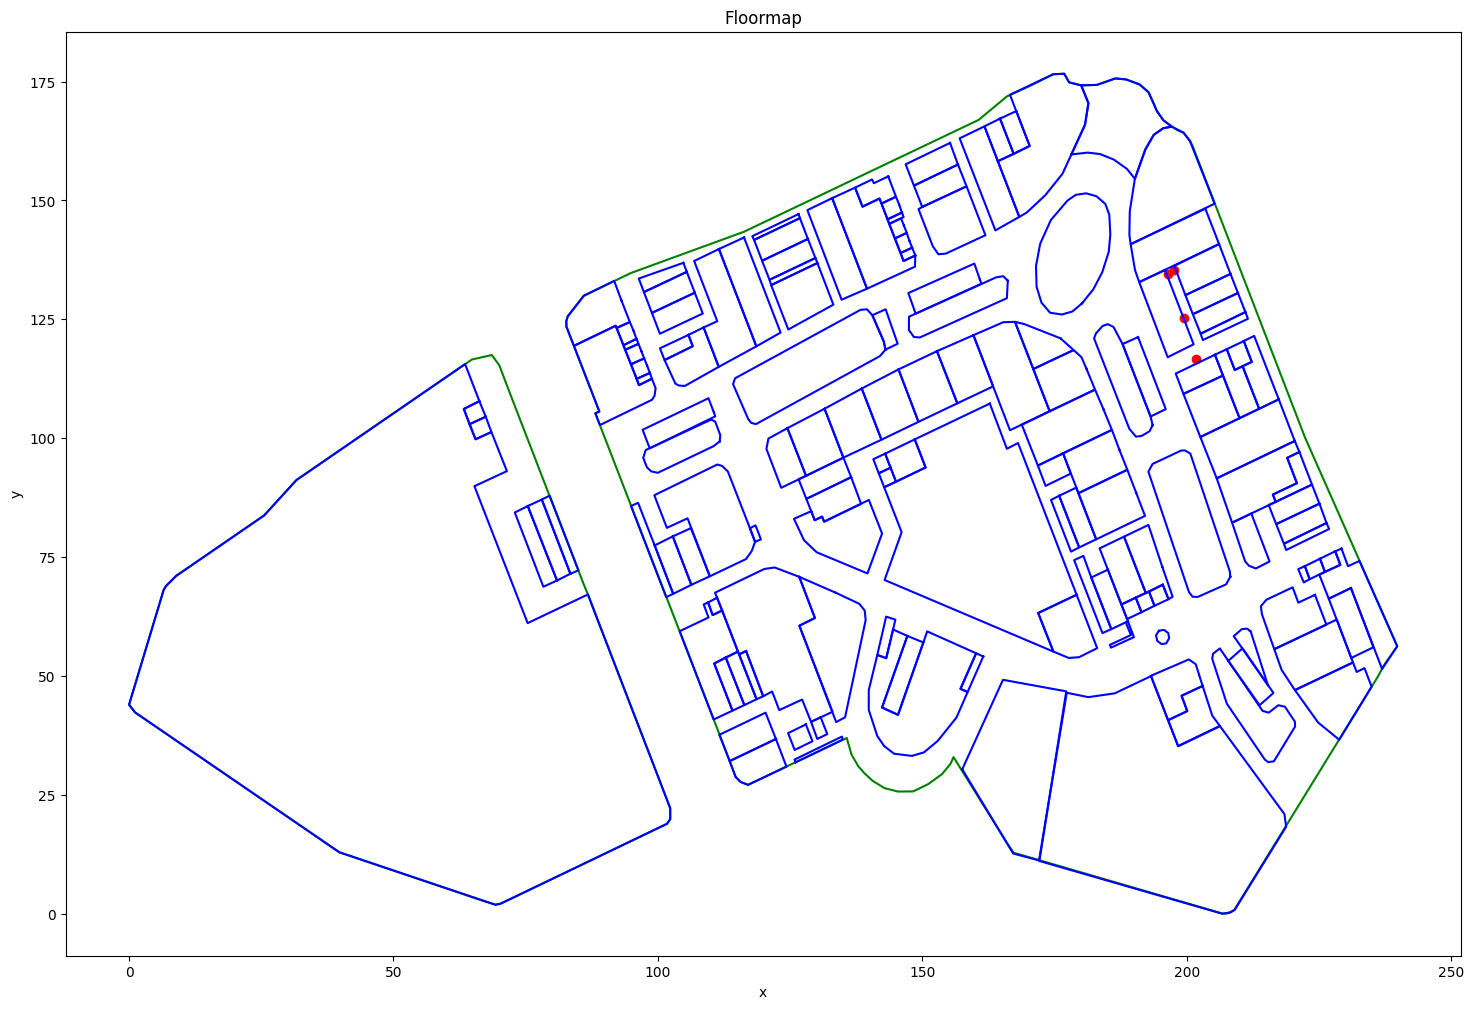

In [295]:
transform_func = transform_rotation(rotation_angle)
floor_polygons, store_polygons, x_min, y_min, x_max, y_max, width_meter, height_meter = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
r_gt_location = transform_func(gt_location)
scale(r_gt_location, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)
ax.scatter(r_gt_location[:, 0], r_gt_location[:, 1], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

#### Search Space Extraction

* Search space is the space occupied by the floor excluding the space occupied by the stores.

In [296]:
union_floor_polygon = shapely_ops.unary_union(floor_polygons)
union_store_polygon = shapely_ops.unary_union(store_polygons)
floor_search_space = union_floor_polygon.difference(union_store_polygon)

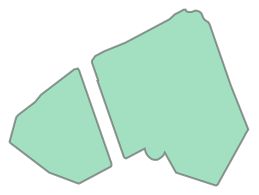

In [297]:
union_floor_polygon

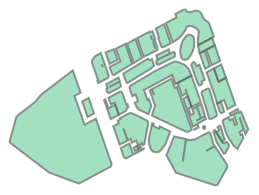

In [298]:
union_store_polygon

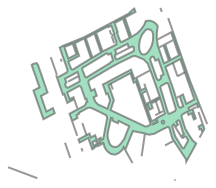

In [300]:
floor_search_space

In [301]:
# Generate search grid

grid_resolution = 2 # 5 meters
grid_xs = np.arange(0, width_meter, grid_resolution) + grid_resolution / 2
grid_ys = np.arange(0, height_meter, grid_resolution) + grid_resolution / 2

grid_x, grid_y = np.meshgrid(grid_xs, grid_ys)

In [302]:
search_space_mask = shapely.vectorized.contains(floor_search_space, grid_x, grid_y)
ss_x, ss_y = grid_x[search_space_mask], grid_y[search_space_mask]

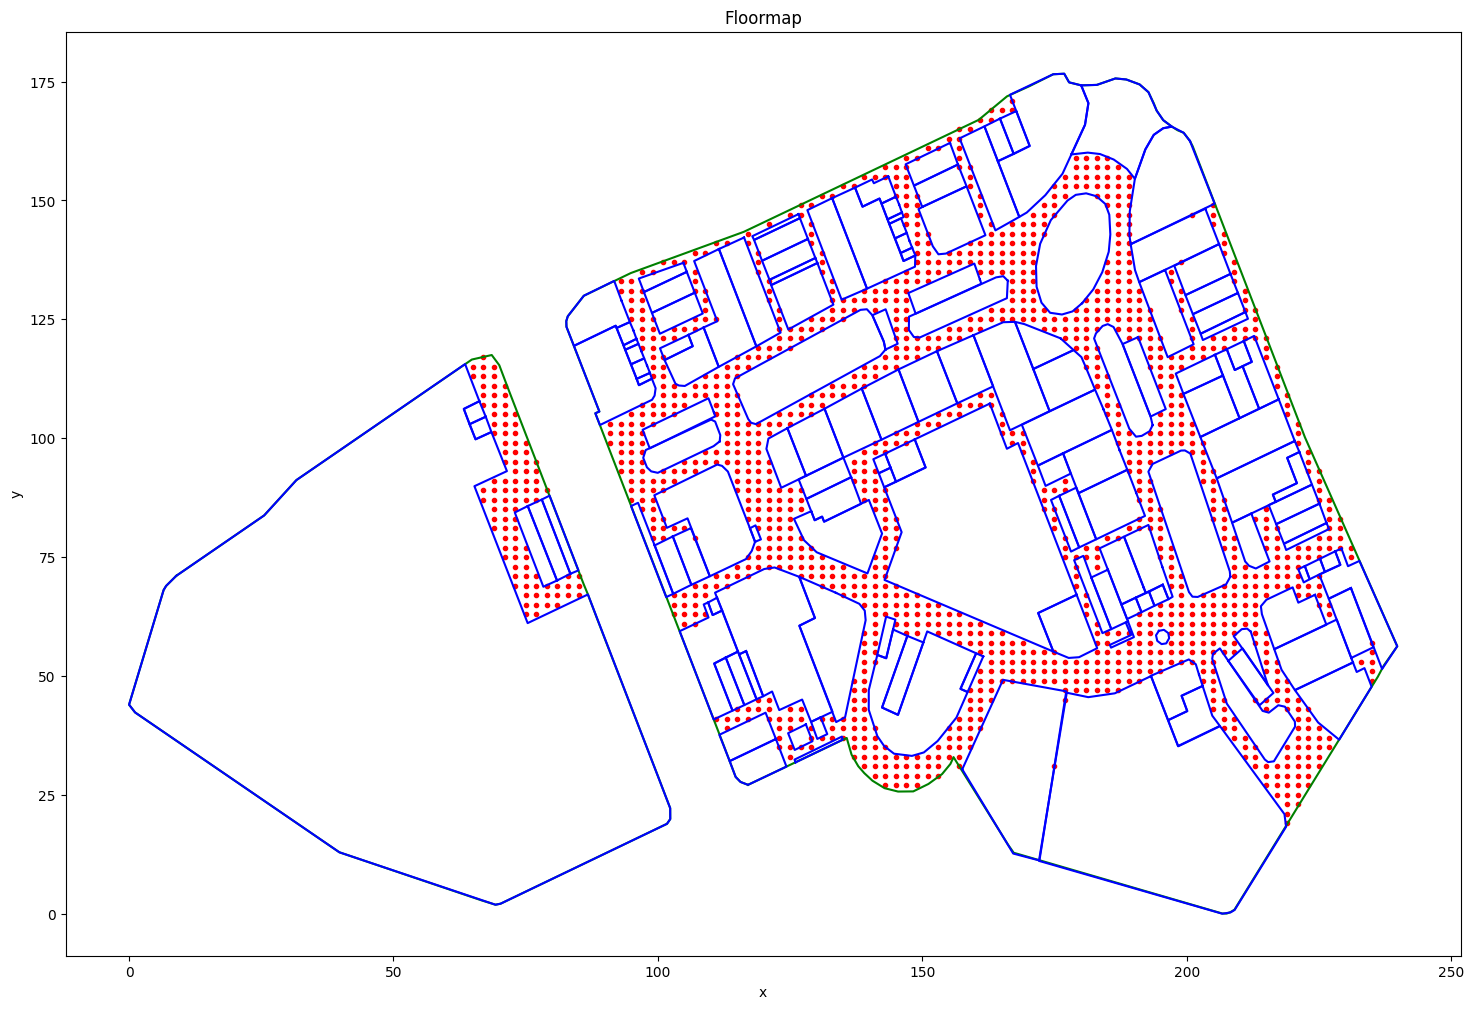

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding search grid
ax.scatter(ss_x, ss_y, marker=".", color="red", label="ss")

plt.ticklabel_format(useOffset=False)
plt.show()


### Implementation of APF

In [305]:
path_datas.acce

array([[ 1.57458832e+12, -6.34475700e-01,  6.17294300e-01,
         8.05792200e+00],
       [ 1.57458832e+12, -4.97421260e-01,  6.15509030e-01,
         8.29553200e+00],
       [ 1.57458832e+12, -8.76892100e-01,  8.72283940e-01,
         8.28057900e+00],
       ...,
       [ 1.57458834e+12,  1.05522160e+00,  1.02909850e+00,
         1.04820400e+01],
       [ 1.57458834e+12,  9.73220800e-01,  8.26797500e-01,
         1.19113770e+01],
       [ 1.57458834e+12,  4.51889040e-01,  1.45945740e+00,
         1.00445100e+01]])